# Ligand-Receptor Inference

As a result of the growing interest in cell-cell communication (CCC) inference, a number of computational tools in single-cell transcriptomics have emerged. Although, there many different categories and approaches to infer CCC events, in this tutorial we will focus on those that infer interactions between ligands and receptors, commonly referred to as ligand-receptor (LR) inference methods (e.g. ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Hou et al., 2020](https://www.nature.com/articles/s41467-020-18873-z), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Raredon et al., 2022](https://www.nature.com/articles/s41598-022-07959-x)). These tools typically rely on gene expression information as a proxy of protein abundance, and they work downstream of data pre-processing and acquisition of biologically-meaningful cell groups. These CCC tools infer intercellular interactions in a hypothesis-free manner, meaning that they infer all possible interactions between cell clusters, relying on prior knowledge of the potential interactions. Here, one group of cells is considered the source of the communication signal, sending a ligand, and the other is the receiver of the signal via its receptors. CCC events are thus represented as interactions between LR pairs, expressed by any combination of source and receiver cell groups.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of LR methods, the interactions can also be represented by heteromeric protein complexes ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x)). 

Here, we will use LIANA to obtain a consensus score for each LR interaction inferred by the different tools. Further, we will make use of LIANA's consensus resource, which combines a number of expert-curated LR resources.

## Environment Setup

In [1]:
library(liana, quietly = T)

library(Seurat, quietly = T)

library(dplyr, quietly = T)
library(reshape2, quietly = T)
library(ggplot2, quietly = T)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Directories

In [188]:
data.path = '/data/hratch/ccc_protocols/interim/' #'../../data/' #<-uncomment in final
output_folder = paste0(data.path, 'liana-outputs/')

## Data Reminder

Here, we will re-load the processed data as processed in Tutorial 01.

**Change this to reading directly from Seurat once tutorial 01 in R is fully completed**

In [3]:
covid_data<-readRDS(paste0(data.path, 'covid_balf_norm.rds'))

just as a quick reminder, let's visualize the cell types and samples in the data.

In [4]:
head(covid_data@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample,sample_new,disease,hasnCoV,cluster,cell.type,condition,percent.mt
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
AAACCCACAGCTACAT-1_1,C100,3123,1376,C100,HC3,N,N,27,B,Control,9.1869398
AAACCCATCCACGGGT-1_1,C100,1429,835,C100,HC3,N,N,23,Macrophages,Control,0.9090909
AAACCCATCCCATTCG-1_1,C100,2342,1105,C100,HC3,N,N,6,T,Control,6.3193851
AAACGAACAAACAGGC-1_1,C100,31378,4530,C100,HC3,N,N,10,Macrophages,Control,9.9815157
AAACGAAGTCGCACAC-1_1,C100,12767,3409,C100,HC3,N,N,10,Macrophages,Control,5.1617451
AAACGAAGTCTATGAC-1_1,C100,2198,1094,C100,HC3,N,N,9,T,Control,8.8717015


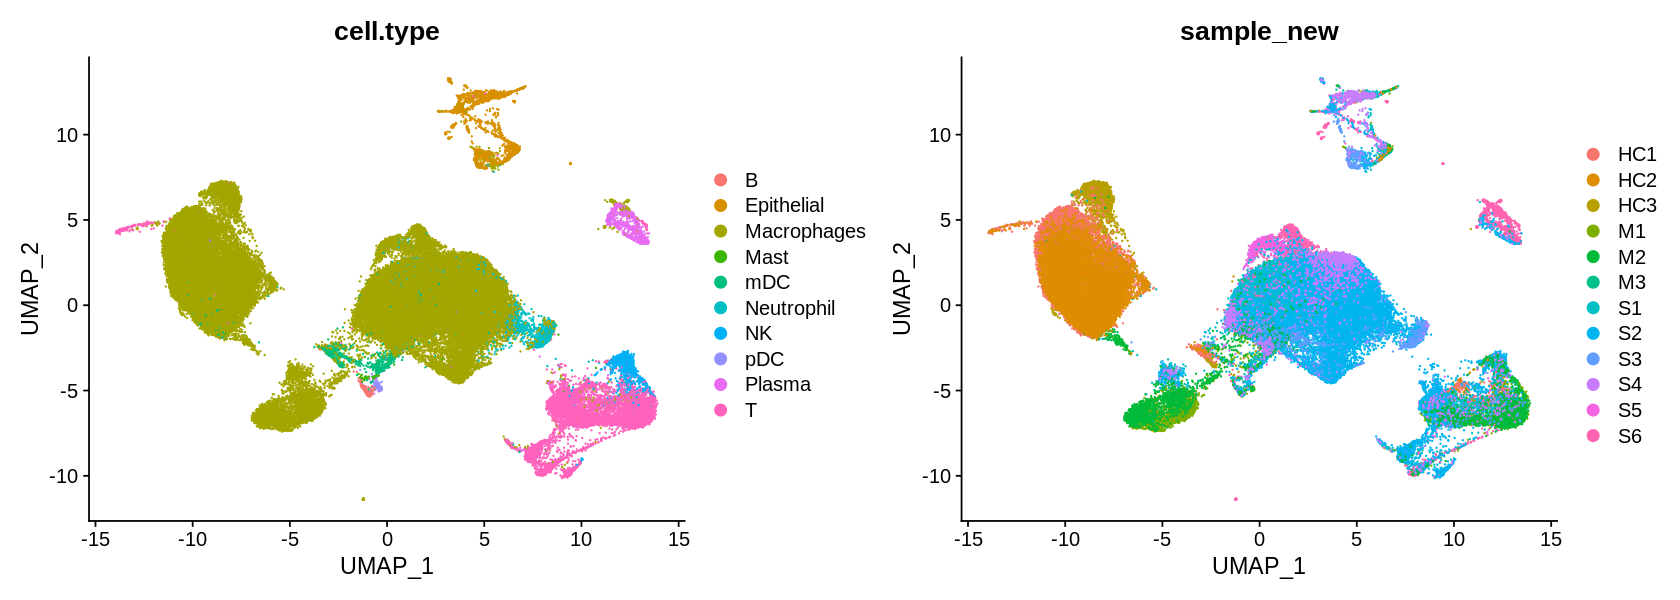

In [5]:
# plot pre-annotated cell types
h_ = 5
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

Idents(covid_data)<-'cell.type'
plot1<-DimPlot(covid_data, reduction = "umap", group.by = 'cell.type')
plot2<-DimPlot(covid_data, reduction = "umap", group.by = 'sample_new')

plot1 + plot2

## Predicting CCC events with LIANA

Now that we have the preprocessed data loaded, we will use liana to score the interactions inferred by the different tools.

`liana` is highly modularized and it implements a number of methods to score LR interactions, we can list those with the following command: 

In [6]:
liana::show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

liana classifies interaction scores into two categories: those that infer the **Magnitude** and **Specificity** of interactions. The **Magnitude** of an interactions is a measure of the strength of the interaction's expression, and the **Specificity** of an interaction is a measure of how specific is an interaction to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score is likely to be specific, and vice versa. 

### UPDATE LIANA'S DIAGRAM

## Scoring Functions

We will now describe the mathematical formulation of the magnitude and specificity scores we will use in this tutorial:

### Shared Notations


`k` is the k-th ligand-receptor interaction 

`L` - expression of ligand L

`R` - expression of receptor R

`C` - cell cluster

`i` - cell group i

`j` - cell group j

`M` - the library-size normalized and log1p-transformed gene expression matrix

`X` - normalized gene expression vector

### CellPhoneDBv2
**Magnitude**: 
<img src="./../../Figures/scoring_functions/lr_mean.svg" alt="" class="bg-primary mb-1" width="250px">

**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.


### Geometric Mean
**Magnitude**:
![lr_means](../../figures/scoring_functions/lr_gmean.svg);

where GeometricMean is calculated as follows:

![geometric_mean](../../figures/scoring_functions/geometric_mean.svg)


**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

### CellChat

**Magnitude**:
![lr_prob](../../figures/scoring_functions/lr_prob.svg)

where `TriMean` represents Tuckey's Trimean function:

![trimean](../../figures/scoring_functions/trimean.svg)

Note that the original CellChat implementation also uses information of mediator proteins, which is specific to the CellChat resource.
Since we are using the consensus resource, we will not use this information, and hence the implementation of CellChat's `LR_probability` in LIANA is simplified to be resource-agnostic.

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

##### The specificity scores of these three method is calculated as follows:

![lr_permutation](../../figures/scoring_functions/lr_permutation.svg)

where `P` is the number of permutations, and `L*` and `R*` are ligand and receptor expression summarized according by each method, i.e. `arithmetic mean` for CellPhoneDB, `TriMean` for CellChat, and `geometric mean` for Geometric Mean.

### SingleCellSignalR

**Magnitude**:
![lrscore](../../figures/scoring_functions/lr_score.svg)

where `mu` is the mean of the expression matrix `M`

### NATMI

**Magnitude**:
![lr_product](../../figures/scoring_functions/lr_product.svg)

**Specificity**:
![specificity_weight](../../figures/scoring_functions/specificity_weight.svg)

### Connectome

**Magnitude**:
![lr_product](../../figures/scoring_functions/lr_product.svg)

**Specificity**:
![zmean](../../figures/scoring_functions/zmean.svg)

where `z` is the z-score of the expression matrix `M`:

![zscore](../../figures/scoring_functions/zscore.svg)

### log2FC

**Specificity**:
![lr_log2fc](../../figures/scoring_functions/lr_log2fc.svg)

where log2FC for each gene is calculated as:

![log2fc](../../figures/scoring_functions/log2fc.svg)


What the above equations show is that there are many commonalities between the different methods, yet there are also many variations in the way the magnitude and specificity scores are calculated. 

![expr_indicator](../../figures/scoring_functions/expr_indicator.svg)

where liana considers interactions as occurring only if the ligand and receptor, and any of their subunits, are expressed in the cell clusters `i`, `j`.
Any interactions that don't pass these criteria are not returned by default, to return them the user can check the `return_all_lrs` parameter.

### Score Distributions

In [7]:
# pick a sample to infer the communication scores for
sdata = subset(x = covid_data, subset = sample == 'C100')
sdata

An object of class Seurat 
24798 features across 2550 samples within 1 assay 
Active assay: RNA (24798 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

The parameters that we will use are the following:
- `idents_col` is the column in the `meta` dataframe that contains the cell groups
- `assay` is a string that indicates which Seurat assay to use (typically `RNA`, unless having done a batch correction step)
- `assay.type` is a string that indicates whether to use the raw (`counts`) or log- and library-normalized (`logcounts`) counts attribute of the Seurat object assay.
- `expr_prop` is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a ligand-receptor pair
- `verbose` is a boolean that indicates whether to print the progress of the function

(Other parameters are described in the documentation of the function, as well as in more detail below)

**Fix this:** assay.type = 'counts' does not work (maybe with SCE but not Seurat object?)

In [8]:
liana_res <- liana_wrap(sce = sdata, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                      expr_prop=0.1, verbose=T, parallelize = T, workers = 30)

Expression from the `RNA` assay will be used

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: Plasma were removed!

Warning message in exec(output, ...):
“5591 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once per session.”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Warning message:
“`progress_estimated()` was deprecated in dplyr 1.0.0.
ℹ The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>.”


liana returns a list of results, each element of which corresponds to a method

In [9]:
liana_res %>% dplyr::glimpse()

List of 5
 $ natmi      : tibble [9,911 × 14] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ target          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ ligand.complex  : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ ligand          : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ receptor.complex: chr [1:9911] "LILRB1" "LILRB1" "ITGAX_ITGB2" "CR2" ...
  ..$ receptor        : chr [1:9911] "LILRB1" "LILRB1" "ITGAX" "CR2" ...
  ..$ receptor.prop   : num [1:9911] 0.111 0.111 0.111 0.111 0.111 ...
  ..$ ligand.prop     : num [1:9911] 0.889 0.778 0.222 0.222 0.222 ...
  ..$ ligand.expr     : num [1:9911] 2.522 2.043 0.377 0.377 0.34 ...
  ..$ receptor.expr   : num [1:9911] 0.237 0.237 0.345 0.173 0.173 ...
  ..$ ligand.sum      : num [1:9911] 19.296 19.192 0.381 0.381 2.687 ...
  ..$ receptor.sum    : num [1:9911] 1.321 1.321 4.268 0.173 0.463 ...
  ..$ prod_weight     : num [1:9911] 0.5985 0.4848 0.1304 0.0652 0.0588 ...
  ..$ edge_

### LIANA's Rank Aggregate

LIANA can calculate an aggregate rank for both `magnitude` and `specificity` as defined above. The `rank_aggregate` function of liana uses a re-implementation of the RobustRankAggregate method by [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/), and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis. It thus provides a consensus of the rank of the ligand-receptor interactions across methods, that can also be treated as a p-value.

In more detail, a rank aggregate is calculated for the `magnitude` and `specificity` scores from the methods in LIANA as follows:

First, a normalized rank matrix[0,1] is generated separately for magnitude and specificity as:

![normalized_rank](../../Figures/scoring_functions/normalized_rank.svg)

where `m` is the number of score rank vectors, `n` is the length of each score vector (number of interactions), **rank<sub>i,j</sub>** is the rank of the `j-th` element (interaction) in the `i-th` score rank vector, and **max(rank<sub>i</sub>)** is the maximum rank in the `i-th` rank vector.

For each normalized rank vector `r`, we then ask how probable is it to obtain **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>**, where **r<sup>null</sup><sub>(k)</sub>** is a rank vector generated under the null hypothesis. The RobustRankAggregate method expresses [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/) the probability **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>** as **β<sub>k,n</sub>(r)**, through a beta distribution. 
This entails that we obtain probabilities for each score vector `r` as:

![rra_pvals](../../Figures/scoring_functions/rra_pvals.svg)

where we take the minimum probability `ρ` for each interaction across the score vectors, and we apply a Bonferroni correction to the p-values by multiplying them by `n` to account for multiple testing.

Aggregate scores are also non-negative, which is beneficial for decomposition with Tensor-cell2cell.

In [69]:
liana_aggregate.magnitude <- liana_aggregate(liana_res = liana_res, aggregate_how='magnitude', verbose = F)
liana_aggregate.specificity <- liana_aggregate(liana_res = liana_res, aggregate_how='specificity', verbose = F)

# format
liana_aggregate.magnitude<-liana_aggregate.magnitude[,which(sapply(colnames(liana_aggregate.magnitude), function(x) !(endsWith(x, '.rank'))))]
liana_aggregate.specificity<-liana_aggregate.specificity[,which(sapply(colnames(liana_aggregate.specificity), function(x) !(endsWith(x, '.rank'))))]

Here, for each scoring type of specificity and magnitude, we can see the different scores for each method as well as the consensus scores. 

Magnitude:

In [70]:
head(liana_aggregate.magnitude)

source,target,ligand.complex,receptor.complex,aggregate_rank,mean_rank,natmi.prod_weight,sca.LRscore,cellphonedb.lr.mean
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T,NK,B2M,KLRC1,3.081547e-12,1,11.67941,0.9585912,3.751150
NK,NK,B2M,KLRC1,2.465238e-11,2,11.62518,0.9584987,3.738849
T,NK,B2M,KLRD1,8.320177e-11,3,11.36870,0.9580527,3.721824
T,T,B2M,CD3D,1.972190e-10,4,11.33366,0.9579907,3.718518
NK,NK,B2M,KLRD1,3.851934e-10,5,11.31590,0.9579591,3.709524
NK,T,B2M,CD3D,6.656142e-10,6,11.28103,0.9578969,3.706217


In [31]:
head(liana_aggregate.specificity)

source,target,ligand.complex,receptor.complex,aggregate_rank,mean_rank,natmi.edge_specificity,connectome.weight_sc,logfc.logfc_comb,cellphonedb.pvalue
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B,B,BTLA,CD79A,9.711377e-11,261.75,0.8376152,8.624422,2.173256,0
B,B,ST6GAL1,CD22,6.523222e-08,326.00,0.3447777,4.390142,1.876454,0
Macrophages,B,FN1,CD79A,1.747077e-07,263.75,0.5999583,6.638458,3.011462,0
Macrophages,B,FN1,NT5E,2.926446e-07,317.75,0.6473695,3.465021,1.839538,0
Mast,pDC,HSPG2,PTPRS,9.770559e-07,409.25,0.9996837,9.966253,1.068425,0
mDC,Mast,CCL17,ACKR2,1.213760e-06,265.75,0.9792987,5.875766,2.629364,0


For clarity, here we map each output score (column names in the above dataframe) to the scoring method and scoring type:

| Method Name | Magnitude Score | Specificity Score |
| :- | -: | :-: |
| CellPhoneDB | lr.mean | cellphonedb.pvalue
| Connectome | prod_weight | weight_sc
| log2FC | None | logfc_comb
| NATMI | prod_weight | edge_specificity
| SingleCellSignalR (sca) | LRscore | None

### Score Distributions

To provide a better illustration of the different scores, we will now plot the distribution of scores for each of the methods.

In [104]:
lamv<-liana_aggregate.magnitude[, sapply(colnames(liana_aggregate.magnitude), function(x) !(endsWith(x, '_rank')))]
lamv<-melt(lamv, id.vars = c('source', 'target', 'ligand.complex', 'receptor.complex'), 
    variable.name = 'score')
lasv<-liana_aggregate.specificity[, sapply(colnames(liana_aggregate.specificity), function(x) !(endsWith(x, '_rank')))]
lasv<-melt(lasv, id.vars = c('source', 'target', 'ligand.complex', 'receptor.complex'), 
    variable.name = 'score')
lav<-rbind(lamv, lasv)

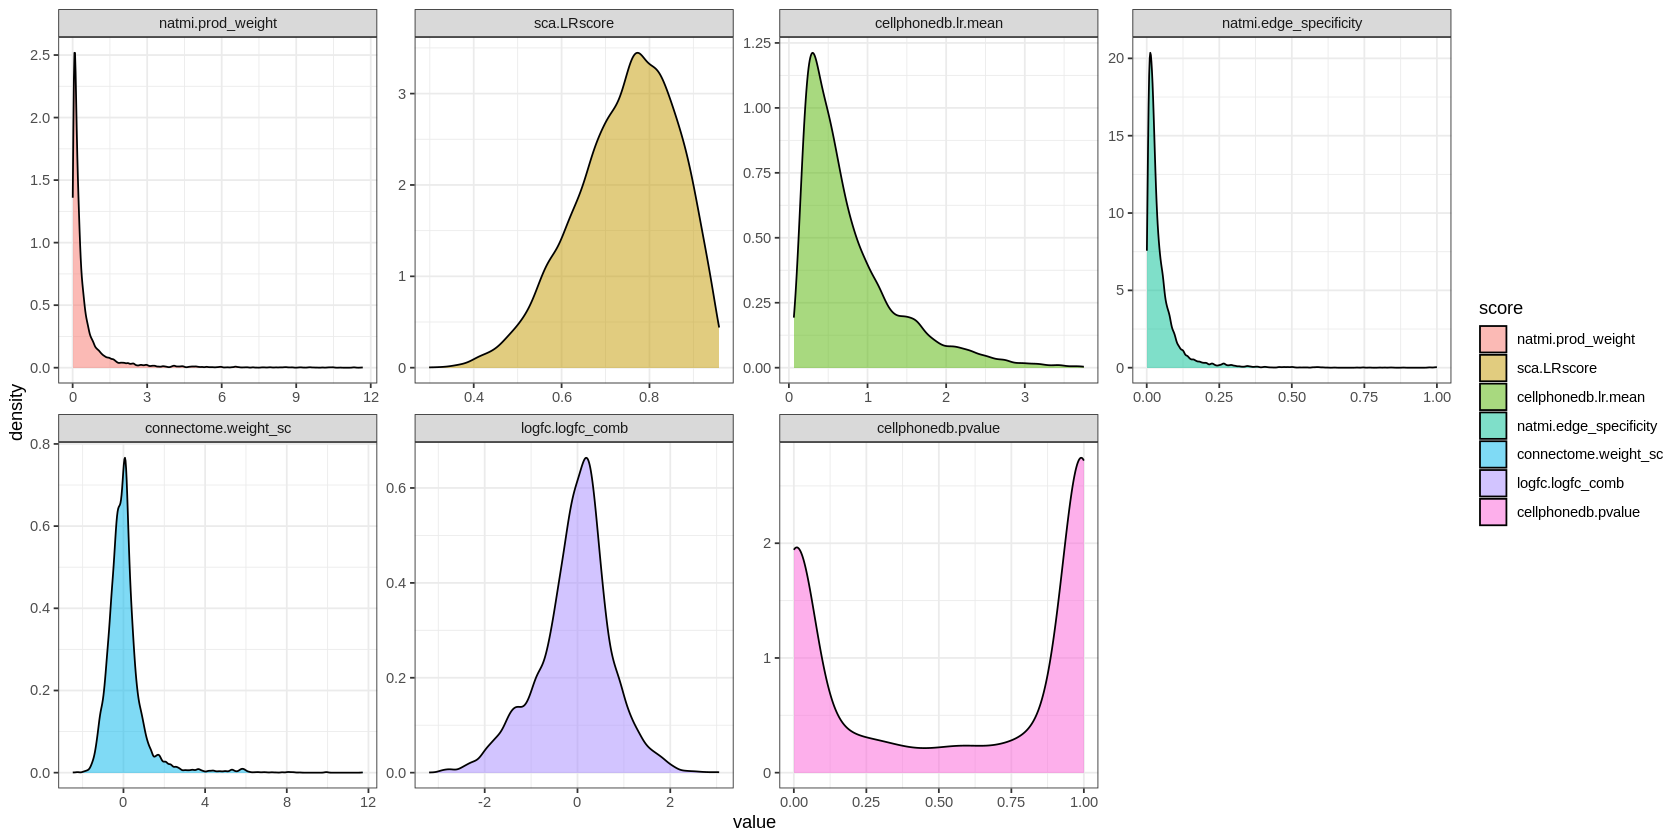

In [109]:
h_ = 7
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

ggplot(lav, aes(x = value, fill = score)) + geom_density(alpha = 0.5) + 
facet_wrap('~score', scales='free', ncol = 4)+
theme_bw()

This show the extent to which  each of the scoring functions differ from each other. Unsurprisingly, independent evaluations have shown that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools ([Dimitrov et al., 2022](https://www.nature.com/articles/s41467-022-30755-0), [Liu et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02783-y), [Wang et al., 2022](https://academic.oup.com/bfg/article/21/5/339/6640320)). This is why we have implemented a consensus score that is a rank aggregate of the scores obtained by the different methods, and for the sake of these tutorials we will use this consensus score to rank the interactions, specifically the one that aggregates the magnitude scores from different functions. Aggregate scores are also non-negative, which is beneficial for decomposition with Tensor-cell2cell.

### Single-Sample Dotplot

Let's generate a basic dotplot with the most highly-ranked ligand-receptor interactions for this sample from LIANA's aggregate scores. 

**Get Daniel's help with this section**: somewhat consistent results, but the scales of the scores are different

In [149]:
joint_cols<-c('source', 'target', 'ligand.complex', 'receptor.complex')

lamv<-plyr::arrange(liana_aggregate.magnitude, source, target, ligand.complex, receptor.complex)
lasv<-plyr::arrange(liana_aggregate.specificity, source, target, ligand.complex, receptor.complex)

if (!(identical(lamv[joint_cols], lasv[joint_cols]))){
    stop('Need specificity and magnitude aggregate interactions to be the same')
}

lav<-lamv[1:5]
lav[[6]]<-lasv[[5]]
colnames(lav)<-c(joint_cols, 'magnitude.rank', 'specificity.rank')

lav<-lav[lav$specificity.rank < 0.05,] # filter by specificty rank as a significance threshold
lav<-plyr::arrange(lav, magnitude.rank) # rank order by magnitude

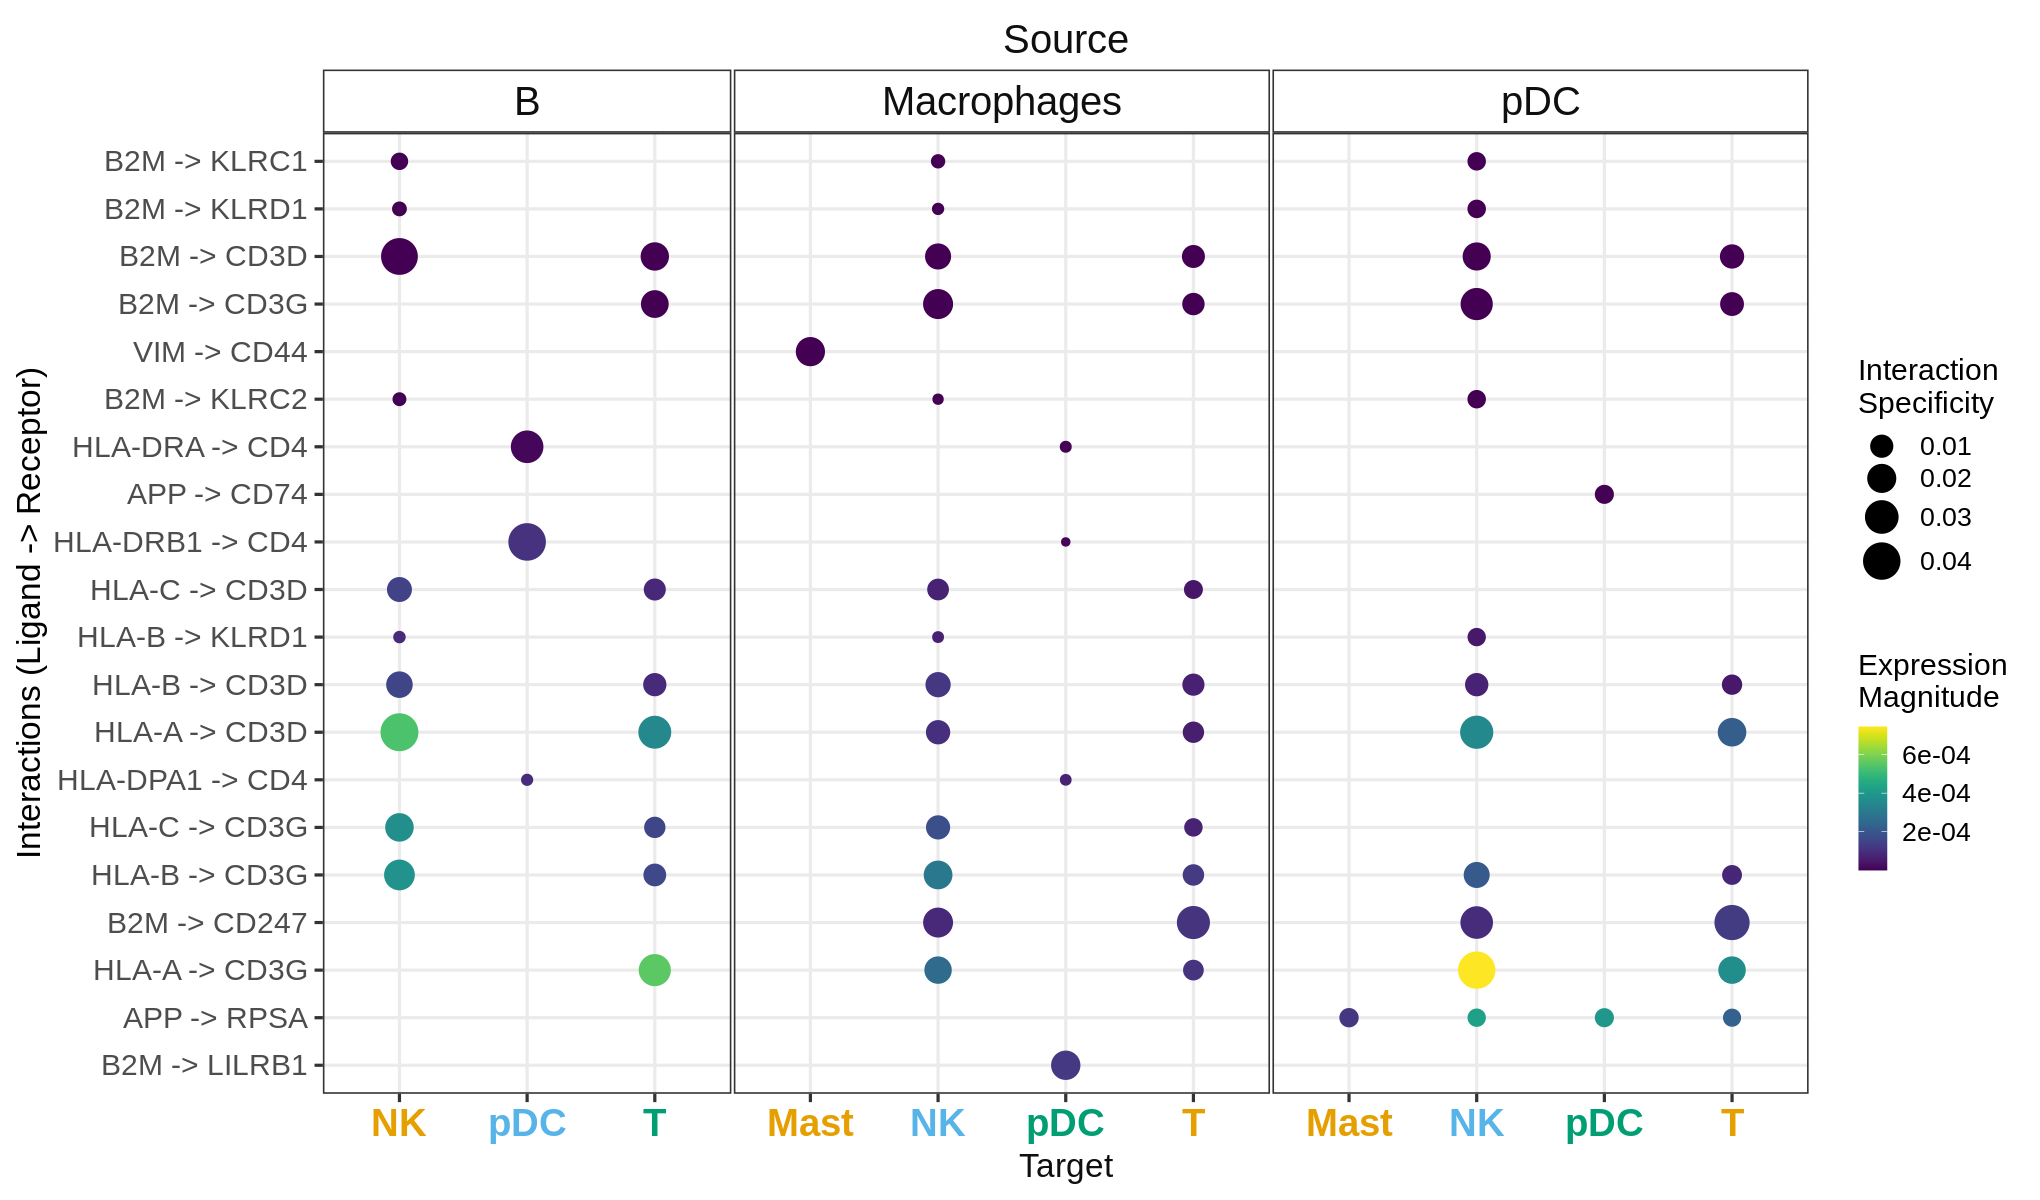

In [167]:
h_ = 10
w_ = 17
options(repr.plot.height=h_, repr.plot.width=w_)

liana_dotplot(
  lav,
  source_groups = c('B', 'Macrophages', 'pDC'),
  target_groups = c('Mast', 'NK', 'T', 'pDC'),
  ntop = 20,
  specificity = "specificity.rank",
  magnitude = "magnitude.rank",
)

Great! We have now obtained ligand-receptor predictions for a single sample. What we see here is that interactions are predicted across cell types and are typically specific to pairs of cell types.

Note that missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`.

## Run LIANA by Sample

Now that we have familiarized ourselves with how ligand-receptor methods in LIANA work and how the results look by sample, let's run LIANA on all of the samples in the dataset. These results will be used to generate a tensor of ligand-receptor interactions across contexts that will be decomposed into CCC patterns by `Tensor-Cell2cell`.

We will repeat the above scoring process, iterating through each sample. We relax the `expr_prop` parameter to have more consistent presence of LR interactions across contexts. See further discussions on the `how` parameter in Tutorial 03. 

In [264]:
context_df_dict<-list()
for (sample.name in sort(unique(covid_data$sample_new))){
    sdata_ = subset(x = covid_data, subset = sample_new == sample.name)
    liana_res_ <- liana_wrap(sce = sdata_, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                          expr_prop=0.05, verbose=F, parallelize = T, workers = 30)

    liana_aggregate.magnitude_ <- liana_aggregate(liana_res = liana_res_, aggregate_how='magnitude', verbose = F)
    
    # retain only the aggregate magnitude rank score
    # and format for input to liana_tensor_c2c function
    liana_aggregate.magnitude_<-liana_aggregate.magnitude_[1:5]
    colnames(liana_aggregate.magnitude_)<-c('source', 'target', 'ligand.complex', 'receptor.complex', 'LRscore')
    liana_aggregate.magnitude_[['sample_new']]<-sample.name
    
    context_df_dict[[sample.name]]<-liana_aggregate.magnitude_
}

Expression from the `RNA` assay will be used

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: Plasma were removed!Cell identities with less than 5 cells: pDC were removed!

Warning message in exec(output, ...):
“5711 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Expression from the `RNA` assay will be used

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: NK were removed!Cell identities with less than 5 cells: pDC were removed!

Warning message in exec(output, ...):
“6729 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Expression from the `R

# you are here

### Check the results

Here, we can combine the results and see that they look very similar as before with the exception that we have an additional column for the sample name, and the results are now by sample.

In [266]:
liana_res_all<-do.call("rbind", context_df_dict)
head(liana_res_all)

source,target,ligand.complex,receptor.complex,LRscore,sample_new
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
T,NK,B2M,CD3D,7.051711e-12,HC1
Macrophages,NK,B2M,CD3D,5.641369e-11,HC1
NK,NK,B2M,CD3D,8.814638e-10,HC1
T,NK,B2M,KLRD1,2.418737e-09,HC1
B,NK,B2M,CD3D,3.610476e-09,HC1
Macrophages,NK,B2M,KLRD1,3.610476e-09,HC1


We can also generate a DotPlot for each sample.
Let's pick the first two distinct interaction in the list, and see what they look like.

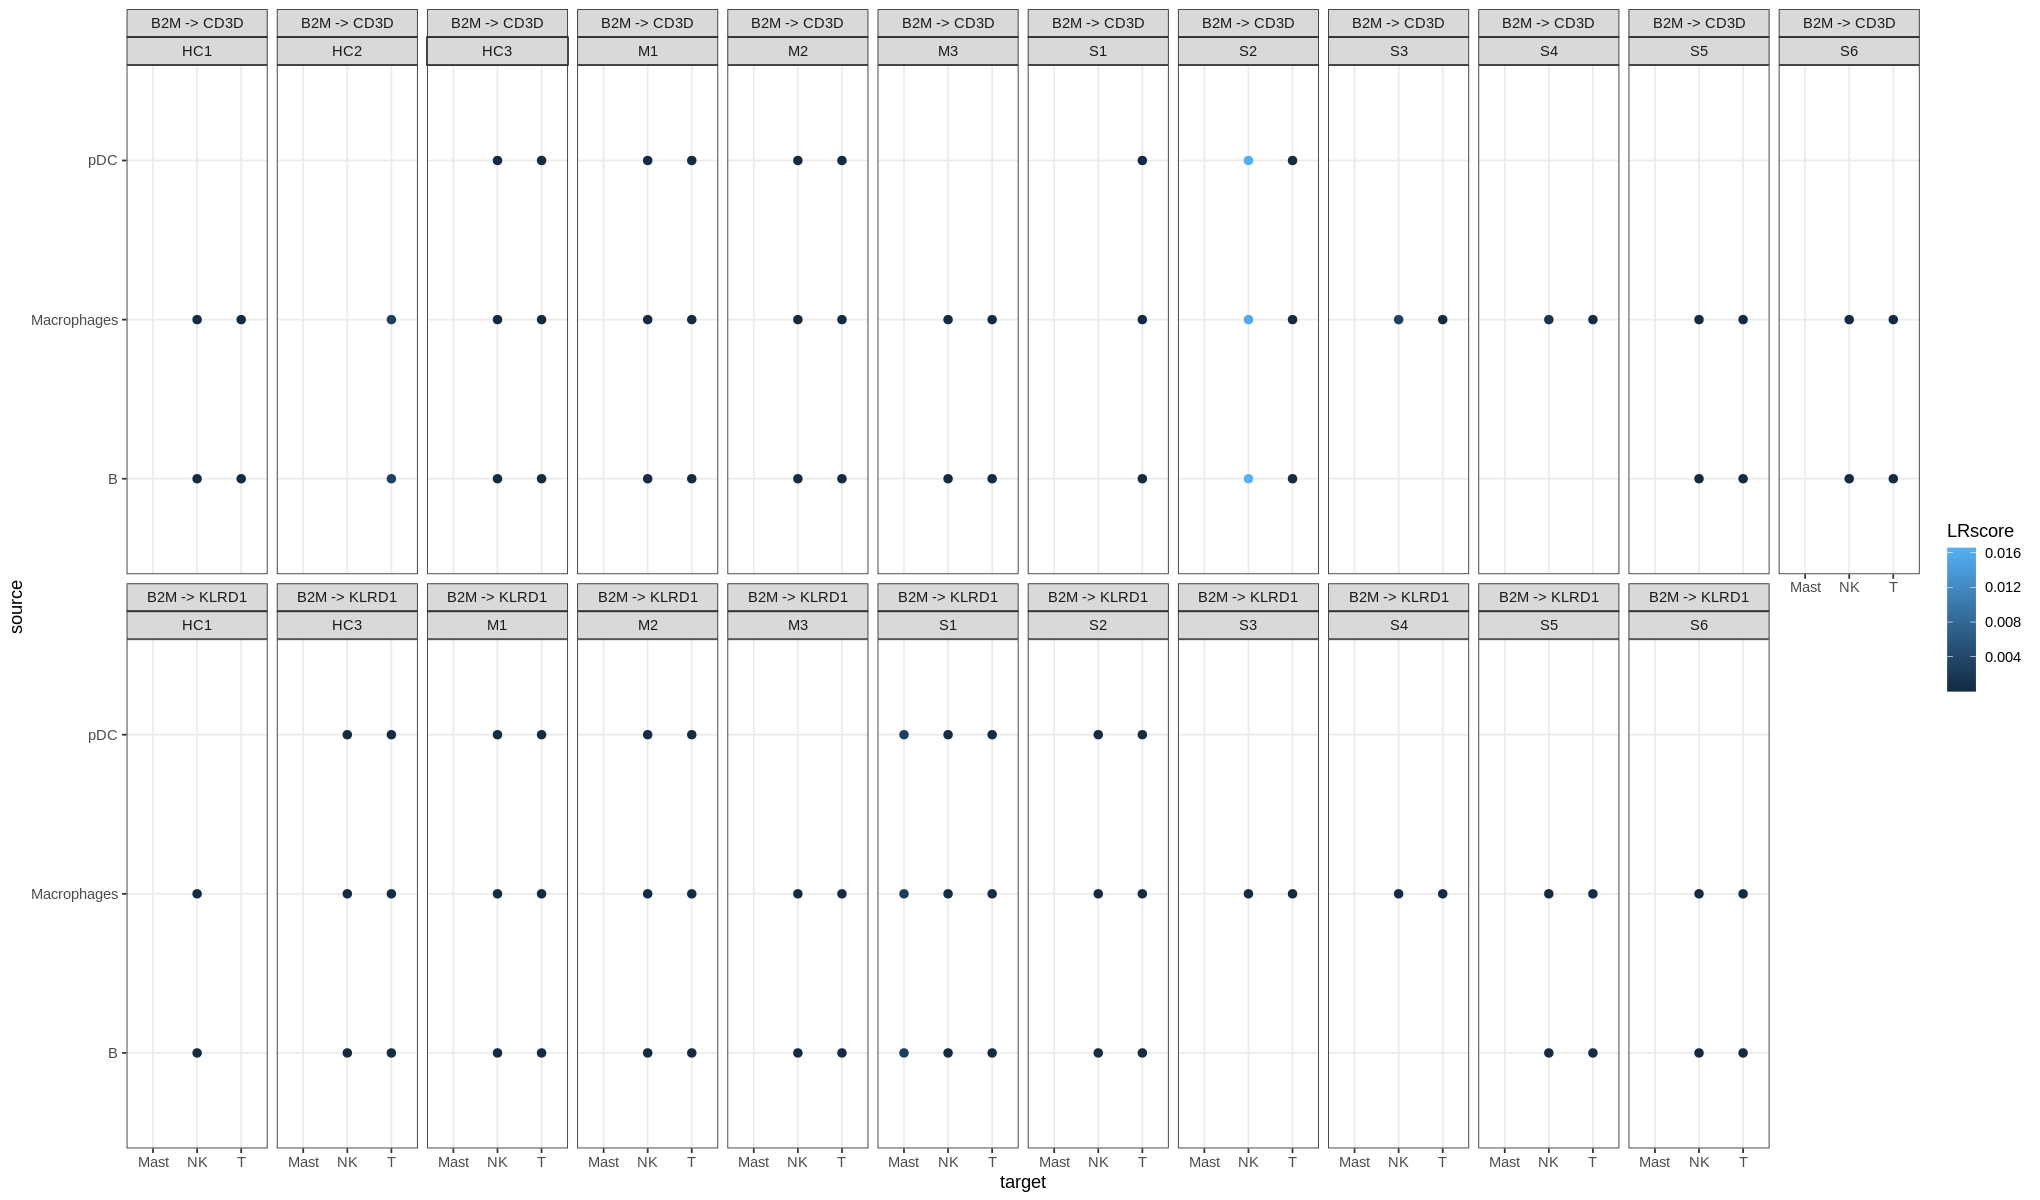

In [295]:
ligand_complex = 'B2M'
receptor_complex = c('CD3D', 'KLRD1')
source_labels=c("B", "pDC", "Macrophages")
target_labels=c("T", "Mast", "pDC", "NK")
sample_key='sample_new'
colour='magnitude_rank'

lv<-liana_res_all
lv<-lv[(lv$source %in% source_labels) & (lv$target %in% target_labels) & (lv$ligand.complex == ligand_complex) & 
   (lv$receptor.complex %in% receptor_complex), ]
lv$lr.pairs<-paste(lv$ligand.complex, lv$receptor.complex, sep = ' -> ')

ggplot(lv, aes(x = target, y = source, color = LRscore)) + geom_point(size = 2) + 
facet_wrap(~ lr.pairs + sample_new , ncol = 12) + 
theme_bw()

Here, we can already see that the ligand-receptor interactions are not only specific to cell types, but also to samples or contexts (see **B2M -> KLRD1** in samples *M1*, *M2*, *M3*). However, we can also see that this plot, even with just two LR interactions visualized, starts to get a bit overwhelming. To this end, to make the most use of the hypothesis-free nature of the ligand-receptor interactions, in the next chapter we will use `Tensor-Cell2cell` to decompose the ligand-receptor interactions into interpretable CCC patterns across contexts.

Save Results for Tensor-Cell2cell. Note that in Tutorial 03, we will proceed with the python version of LIANA outputs (see "Supplementary Information - Comparison with Python output" section for details). However, the above generated `context_df_dict` variable can be used in place of that in Tutorial 03 to have direct continuity with these outputs. 

In [296]:
saveRDS(context_df_dict, paste0(output_folder, 'LIANA_by_sample_R.rds'))

## Supplementary Information about LIANA

### Key Parameters

We already covered some of the parameters in LIANA, that can be used to customize the results. Here, we will go in more detail over some of the most important ones.


- `resource` and `resource_name` enable the user to select the resource that they want to use for CCC inference. By default, liana will use the 'consensus' resource which combines a number of expert-curated ligand-receptor resources. However, one can also use the 'cellphonedb' resource, any of the resources that are available within liana by passing their `resource_name` (See below). Additionally, the user can pass their own resource via the `resource` parameter, which expects a pandas DataFrame.


In [297]:
show_resources()

[1] "Default"          "Consensus"        "Baccin2019"       "CellCall"        
 [5] "CellChatDB"       "Cellinker"        "CellPhoneDB"      "CellTalkDB"      
 [9] "connectomeDB2020" "EMBRACE"          "Guide2Pharma"     "HPMR"            
[13] "ICELLNET"         "iTALK"            "Kirouac2010"      "LRdb"            
[17] "Ramilowski2015"   "OmniPath"         "MouseConsensus"


- `expr_prop` which we also used before is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a potential ligand-receptor pair. This is a parameter that can be used to filter out lowly-expressed ligand-receptor pairs. This is common practice in CCC inference at the cluster level, as we make the assumption that the event occurs for all cells within that clusters.

- `return_all_lrs` is related to the `expr_prop` parameter. If `return_all_lrs` is set to `True`, then all ligand-receptor pairs will be returned, regardless of whether they are expressed above the `expr_prop` threshold. This is useful if one wants to use the `expr_prop` parameter to filter out lowly-expressed ligand-receptor pairs, but still wants to see the scores for all ligand-receptor pairs.

In addition to those parameters liana provides a number of other utility parameters as well as some method-specific ones, please refer to the documentation for more information.

### Using the `liana_bysample` function directly

If you have a specific scoring method in mind, you can use the `liana_bysample` function directly. This function requires a `SingleCellExperiment` object, so we will first need to convert our Seurat object.

In [ ]:
covid_data<-Seurat::as.SingleCellExperiment(covid_data)

covid_data <- liana_bysample(sce = sce,
                      sample_col = "sample_new", # context dimension
                      idents_col = "ident", # cell types
                      expr_prop = 0.05, 
                      assay='RNA', 
                      assay.type = 'logcounts',
                      verbose = TRUE ,
                        method = 'sca'
                      parallelize = TRUE, workers = 30
                      )

The output of this function can directly be input to the `liana_tensor_c2c` function used in Tutorial 03. For more details, see liana's tensor-cell2cell [tutorial](https://saezlab.github.io/liana/articles/liana_cc2tensor.html). 

### Rank Comparisons

**Probably want to remove this**
Let's see how the specificty and magnitude aggregate scores compare using a Spearman correlation:

In [166]:
cor.test(lav$magnitude.rank, lav$specificity.rank, method = c('spearman'))$estimate[['rho']]

Warning message in cor.test.default(lav$magnitude.rank, lav$specificity.rank, method = c("spearman")):
“Cannot compute exact p-value with ties”


[1] 0.2294075

#### Comparison with Python output:

There are minor differences with the LIANA implementation in python that lead to outputs not being identical

- SingleCellSignalR Magnitude (LRscore): slightly different after 3rd decimal place
- LogFC Specificity (logfc_comb): similar relative differences but different exact values
- CellPhoneDB Specificity (pvalue): similar relative differences but different exact values
- CellChat: not run by default in R

To have complete consistency with Python between, for example, the magnitude aggregate rank score, we can run LIANA using the two methods that are 100% consistent between the two languages (CellPhoneDB and NATMI) and re-calculate our magnitude score from just those two. 

In [183]:
liana_res_partial <- liana_wrap(sce = sdata, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                      expr_prop=0.1, verbose=T, parallelize = T, workers = 30, 
                      method = c("natmi", "cellphonedb"))
liana_aggregate_partial <- liana_aggregate(liana_res = liana_res_partial, 
                                           aggregate_how='magnitude', verbose = F)
liana_aggregate_partial<-liana_aggregate_partial[c('source', 'target', 'ligand.complex', 'receptor.complex', 'aggregate_rank')]

head(liana_aggregate_partial)

source,target,ligand.complex,receptor.complex,aggregate_rank
<chr>,<chr>,<chr>,<chr>,<dbl>
T,NK,B2M,KLRC1,2.036081e-08
NK,NK,B2M,KLRC1,8.144324e-08
T,NK,B2M,KLRD1,1.832473e-07
T,T,B2M,CD3D,3.257730e-07
NK,NK,B2M,KLRD1,5.090202e-07
NK,T,B2M,CD3D,7.329891e-07


Because the rank aggregation **insert explanation here**, the aggregated magnitude rank scores slightly differ in absolute value. However, they agree highly in terms of relative values, as seen by the Spearman correlation:

In [243]:
liana_aggregate_partial<-plyr::arrange(liana_aggregate_partial, source, target, ligand.complex, receptor.complex)
write.csv(liana_aggregate_partial, paste0(output_folder, 'magnitude_ranks_R.csv'))

# read and format python aggregate rank
lap_python<-read.csv(paste0(output_folder, 'magnitude_ranks_python.csv'))
clp<-colnames(lap_python)
clp[4]<-'ligand.complex'
clp[5]<-'receptor.complex'
colnames(lap_python)<-clp
lap_python<-lap_python[colnames(lap_python) != 'X']

# merge the two scores
la<-dplyr::inner_join(liana_aggregate_partial, lap_python)

spearmanr<-cor.test(la$aggregate_rank, 
         la$magnitude_rank, method = c('spearman'))$estimate[['rho']]
print(paste0('The spearman correlation is: ', spearmanr))

Joining with `by = join_by(source, target, ligand.complex, receptor.complex)`
Warning message in cor.test.default(la$aggregate_rank, la$magnitude_rank, method = c("spearman")):
“Cannot compute exact p-value with ties”


[1] "The spearman correlation is: 0.977294079830862"


In [245]:
liana_aggregate.magnitude<-plyr::arrange(liana_aggregate.magnitude, source, target, ligand.complex, receptor.complex)
write.csv(liana_aggregate.magnitude, paste0(output_folder, 'magnitude_ranks_all_R.csv'))


Since there are slight inconsistencies in the scores between the two languages, we will use the Python aggregate magnitude rank score in proceeding tutorials for both R and python. 